In [11]:
# tools
import pandas as pd
import matplotlib.pyplot as plt

# data
from neuralforecast.utils import AirPassengersDF

# forecast
from neuralforecast.core import NeuralForecast

# models
from neuralforecast.auto import AutoMLP
from neuralforecast.models import NBEATS, NHITS

# model tune
from ray import tune

import warnings
warnings.filterwarnings("ignore")

# data

In [12]:
Y_df = AirPassengersDF
Y_df = Y_df.reset_index(drop = True)
print(Y_df.head())
print()
print(Y_df.shape)
print()
print(Y_df["unique_id"].value_counts())

   unique_id         ds      y
0        1.0 1949-01-31  112.0
1        1.0 1949-02-28  118.0
2        1.0 1949-03-31  132.0
3        1.0 1949-04-30  129.0
4        1.0 1949-05-31  121.0

(144, 3)

unique_id
1.0    144
Name: count, dtype: int64


# model training

In [ ]:
horizon = 12
models = [
    NBEATS(input_size=2 * horizon, h=horizon, max_steps=50),
    NHITS(input_size=2 * horizon, h=horizon, max_steps=50),
    # Ray tune explore config
    AutoMLP(
        config = dict(
            max_steps = 100, # Operates with steps not epochs
            input_size = tune.choice([3 * horizon]),
            learning_rate = tune.choice([1e-3])
        ),
        h = horizon,
        num_samples = 1, 
        cpus = 1
    )
]
nf = NeuralForecast(models = models, freq = "M")
nf.fit(df = Y_df)

2024-12-06 15:50:09,812	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-12-06 15:50:09,822	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/wangzf/ray_results/_train_tune_2024-12-06_15-13-26' in 0.0073s.


# model predicting

In [4]:
Y_hat_df = nf.predict().reset_index()
Y_hat_df

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                       | 0/? [00:…

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                       | 0/? [00:…

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                       | 0/? [00:…

,unique_id,ds,NBEATS,NHITS,AutoMLP
0,1.0,1961-01-31,444.843994,450.828674,454.914276
1,1.0,1961-02-28,465.888672,468.820312,430.188416
2,1.0,1961-03-31,473.316284,478.532166,458.478546
3,1.0,1961-04-30,492.467590,508.529633,477.244537
4,1.0,1961-05-31,533.140625,562.374878,522.253052
5,1.0,1961-06-30,621.205811,595.129822,608.805725
6,1.0,1961-07-31,676.865417,657.690613,694.153320
7,1.0,1961-08-31,669.748047,657.416077,689.863525
8,1.0,1961-09-30,586.466064,598.208740,583.123657
9,1.0,1961-10-31,508.629761,566.697266,511.057037


<Figure size 1200x300 with 0 Axes>

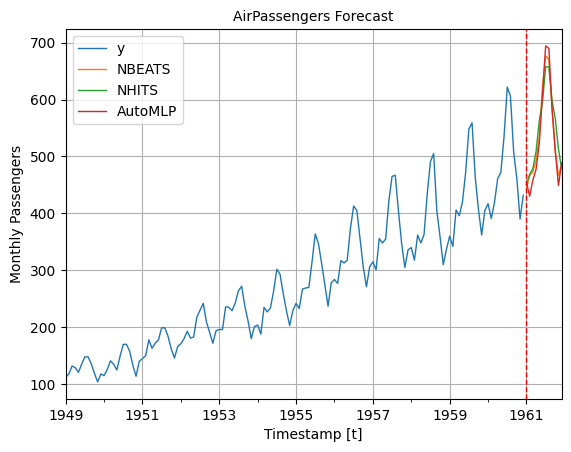

In [7]:
plot_df = pd.concat([Y_df, Y_hat_df]).set_index('ds')

plt.figure(figsize = (12, 3))
plot_df[['y', 'NBEATS', 'NHITS', 'AutoMLP']].plot(linewidth=1.0)
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)
plt.axvline(x = plot_df.index[-horizon], color='r', linestyle='--', linewidth=1.0)
plt.legend(prop={'size': 10})
plt.grid()

# model save

In [26]:
nf.save(
    path = "./checkpoints/test_run/",
    model_index = None,
    overwrite = True,
    save_dataset = True,
)

# model load

In [27]:
nf2 = NeuralForecast.load(path = "./checkpoints/test_run/")
Y_hat_df = nf2.predict().reset_index()
Y_hat_df

Global seed set to 1
Global seed set to 1
Global seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

,unique_id,ds,AutoMLP,NBEATS,NHITS
0,1.0,1961-01-31,454.914154,444.368103,450.529510
1,1.0,1961-02-28,430.188354,464.821472,468.269562
2,1.0,1961-03-31,458.478607,472.306366,478.337708
3,1.0,1961-04-30,477.244476,493.174072,509.043457
4,1.0,1961-05-31,522.253052,531.443726,562.544495
5,1.0,1961-06-30,608.805603,621.822571,595.196106
6,1.0,1961-07-31,694.153198,678.368225,658.282471
7,1.0,1961-08-31,689.863464,668.124023,658.865540
8,1.0,1961-09-30,583.123596,585.601257,598.597290
9,1.0,1961-10-31,511.057098,506.837067,565.858276


# result

<Figure size 1200x300 with 0 Axes>

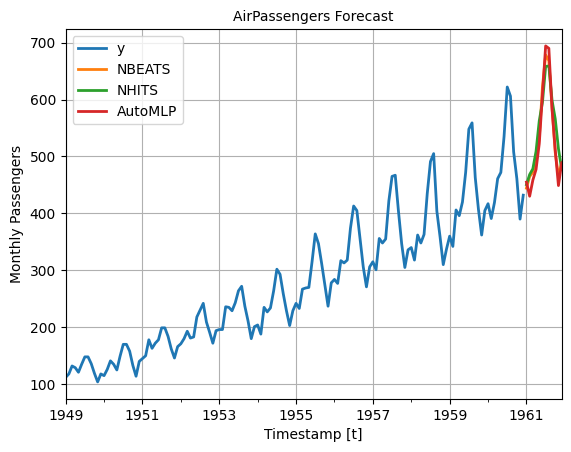

In [30]:
plot_df = pd.concat([Y_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes

plt.figure(figsize = (12, 3))
plot_df[['y', 'NBEATS', 'NHITS', 'AutoMLP']].plot(linewidth=1.5)
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)
plt.axvline(x=plot_df.index[-horizon], color='k', linestyle='--', linewidth=1.0)
plt.legend(prop={'size': 10})
plt.grid()